<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

# Description de l'entreprise 📇

AT&T Inc. est une société de portefeuille multinationale américaine dans le secteur des télécommunications, dont le siège est situé à la tour Whitacre dans le centre-ville de Dallas, au Texas. C'est la plus grande société de télécommunications au monde en termes de revenus et le troisième plus grand fournisseur de services de téléphonie mobile aux États-Unis. En 2022, AT&T occupait la 13e place dans le classement Fortune 500 des plus grandes sociétés américaines, avec un chiffre d'affaires de 168,8 milliards de dollars ! 😮

# Projet 🚧

Un des principaux problèmes rencontrés par les utilisateurs d'AT&T est l'exposition constante aux messages indésirables (SPAM).

AT&T a été capable de signaler manuellement les messages indésirables pendant un certain temps, mais ils recherchent un moyen automatisé de détecter les spams pour protéger leurs utilisateurs.

# Objectifs 🎯

Votre objectif est de construire un détecteur de spams qui peut automatiquement signaler les spams au fur et à mesure qu'ils arrivent, basé uniquement sur le contenu des SMS.

# Livrable 📬

Pour mener à bien ce projet, votre équipe devrait :

* Rédiger un notebook qui effectue le prétraitement et entraîne un ou plusieurs modèles d'apprentissage en profondeur afin de prédire la nature
spam ou ham des SMS.
* Indiquer clairement les performances obtenues.

# Importation des libraries et du dataset

In [3]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from nltk import bigrams
from nltk.tokenize import word_tokenize

import re
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33671\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33671\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Importation des données
data = pd.read_csv("spam.csv", encoding='latin1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# EDA

### Analyse globale et transformation du dataset

In [3]:
data.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [4]:
# Suppression des colonnes inutiles + renommage des colonnes
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

data.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

(data.head())

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Statistiques visuels des Labels

Identifions tout d'abord la répartition de notre dataset entre le nombre de spams et de ham

In [5]:
# Statistiques visuels des labels
print(data['label'].value_counts())

ham     4825
spam     747
Name: label, dtype: int64


c:\Users\33671\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


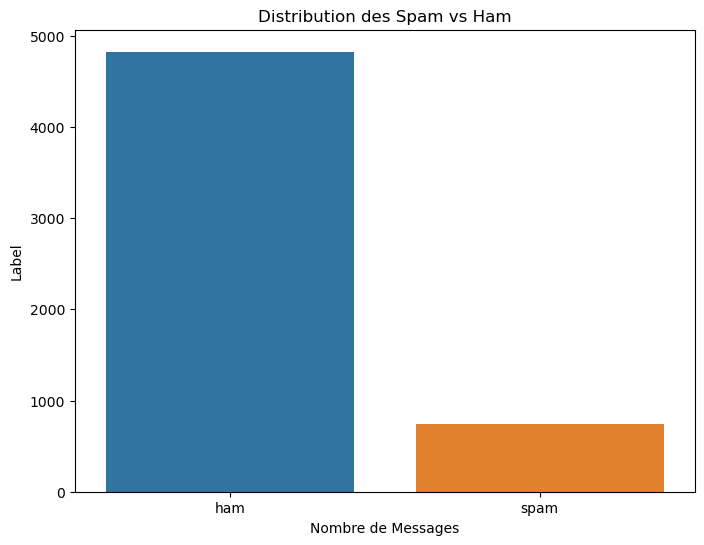

In [6]:
# plot de la distribution des Spams vs Ham
plt.figure(figsize=(8, 6))
sns.countplot(data['label'])
plt.title('Distribution des Spam vs Ham')
plt.xlabel('Nombre de Messages')
plt.ylabel('Label')
plt.show()

### Analyse de la longueur des messages

Analysons ensuite la longueur des messages de notre dataset et les différences entre les messages ham et spams pour avoir un meilleur visuel quantitatif.

In [7]:
# Ajout d'une nouvelle colonne 'length' qui contient la longueur de chaque message
data['length'] = data['message'].apply(len)

data['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

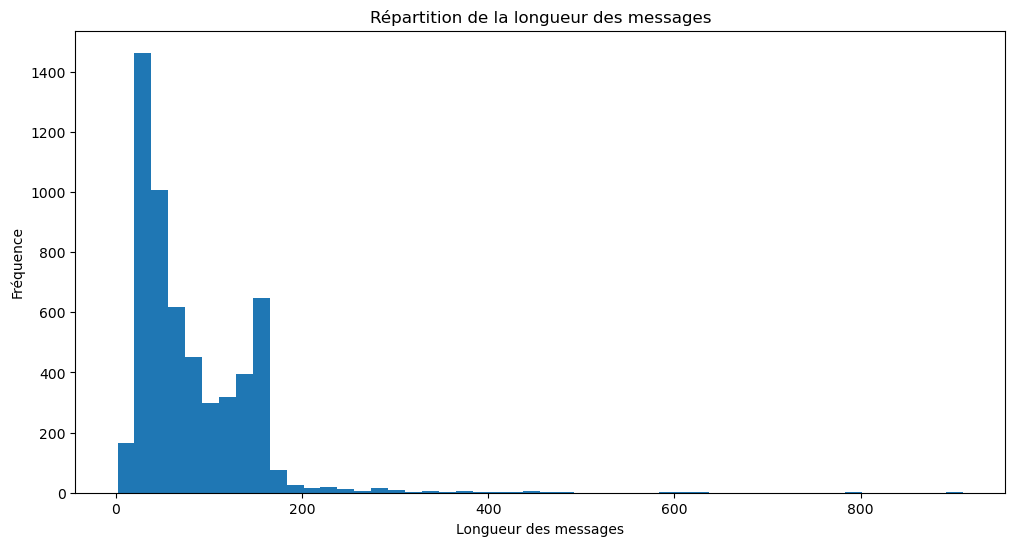

In [8]:
# Plot de la répartion de la longueur des messages
plt.figure(figsize=(12, 6))
data['length'].plot(kind='hist', bins=50)
plt.title('Répartition de la longueur des messages')
plt.xlabel('Longueur des messages')
plt.ylabel('Fréquence')
plt.show()

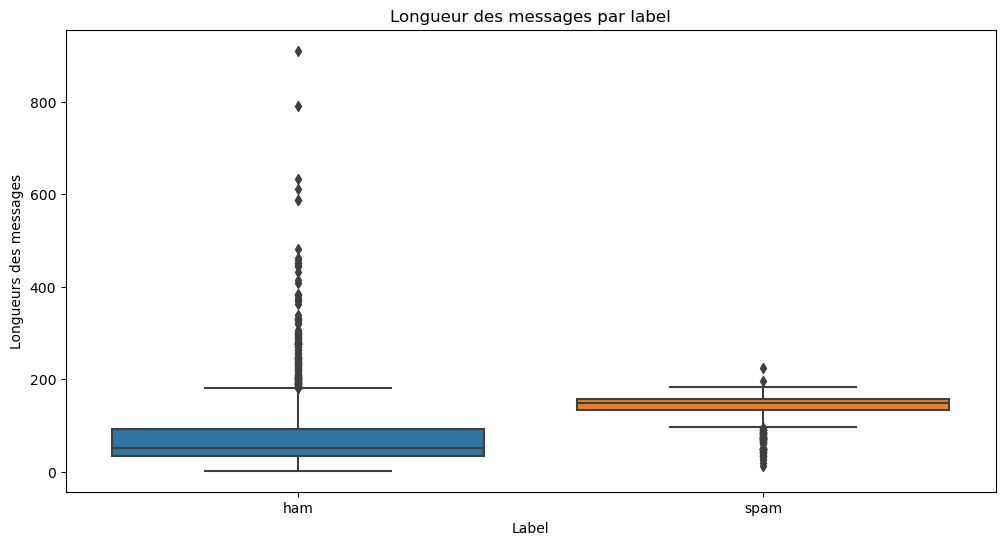

In [9]:
# Plot Longueur des messages par label
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='length', data=data)
plt.title('Longueur des messages par label')
plt.xlabel('Label')
plt.ylabel('Longueurs des messages')
plt.show()

Les messages légitimes ("ham") sont généralement plus longs et variés que les spams, qui sont plus courts et uniformes. 

Cette caractéristique peut être exploitée pour améliorer les algorithmes de détection de spam de manière à augmenter la précision et réduire les faux positives en ciblant plus efficacement les spams.

### Analyse des mots des 2 labels "ham" et "spam"

Pour améliorer la distinction entre les labels, examinons les mots les plus fréquents par catégorie afin de détecter des tendances ou des sentiments distinctifs.

In [10]:
# Filtrage et extraction des messages non-spam (ham) et spam du dataFrame 'data'
ham_messages = data[data['label'] == 'ham']['message']
spam_messages = data[data['label'] == 'spam']['message']

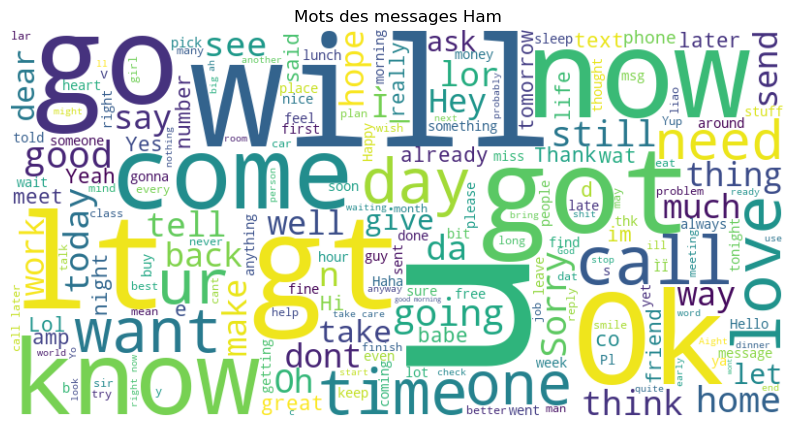

In [11]:
# Affichage du wordcloud de ham
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(ham_messages))
plt.figure(figsize=(10, 8))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Mots des messages Ham')
plt.show()

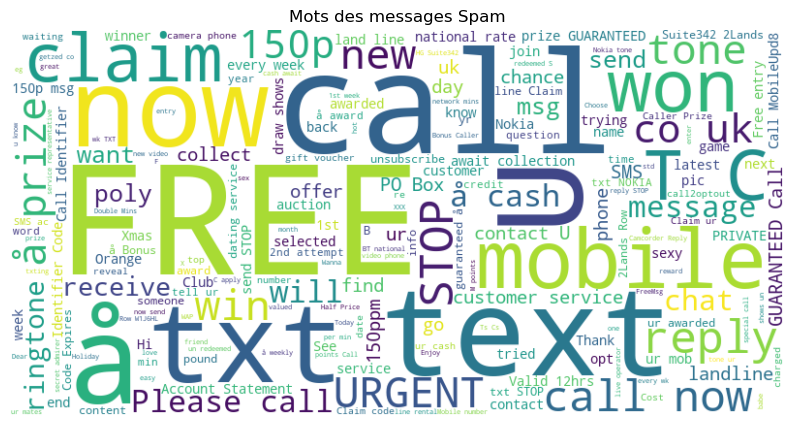

In [12]:
# Affichage du wordcloud de spam
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(spam_messages))
plt.figure(figsize=(10, 8))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Mots des messages Spam')
plt.show()

Sans surprise, nous pouvons constater que les mots dans le nuage de mots des messages 'ham' sont diversifiés, tandis que ceux des messages 'spam' comportent typiquement des mots liés à la publicité et à l'action, tels que 'free', 'call', 'now', et 'mobile'.

Cette distinction lexicale est fondamentale pour l'efficacité du modèle, car elle exploite les schémas de langage récurrents des spams pour renforcer la capacité de classification entre les messages 'ham' et 'spam'.

### Calculs de la fréquence des mots

Pour optimiser la performance du modèle et renforcer notre analyse par rapport au stopwords, il est crucial de calculer la fréquence des mots dans chaque catégorie de message. Cette démarche permet d'identifier les termes prédominants et leur récurrence, facilitant ainsi la distinction entre les messages 'ham' et 'spam'. 

C'est pourquoi, nous allons appliquer une fonction de nettoyage du texte, visant à retirer tout tokens non alphabétiques et les stopswords de façon à n'avoir que des mots ayant un caractère de sens important dans les textes.

In [13]:
# Fonction de nettoyage du texte
def clean_text(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation) # Suppression de la ponctuation
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()] # Filtrage pour ne conserver que les tokens qui sont alphabétiques
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words] # Filtrage pour retirer les stopwords
    return words

In [14]:
# Applique la fonction de nettoyage
ham_words = clean_text(" ".join(ham_messages))
spam_words = clean_text(" ".join(spam_messages))


In [15]:
# Calcul la fréquence des mots
ham_word_freq = pd.Series(ham_words).value_counts()
spam_word_freq = pd.Series(spam_words).value_counts()

In [16]:
# Affiche les mots les plus commmuns et leurs nombre dans les colonne Ham et Spam
print("Les mots les plus communs dans Ham :\n", ham_word_freq.head(10))
print("\nLes mots les plus communs dans Spam:\n", spam_word_freq.head(10))

Les mots les plus communs dans Ham :
 u       1004
nt       360
gt       318
lt       316
get      303
ok       279
go       248
got      244
ur       241
know     236
dtype: int64

Les mots les plus communs dans Spam:
 call      347
free      219
u         159
txt       156
ur        144
mobile    123
text      121
stop      116
claim     113
reply     104
dtype: int64


### Analyse des N-grammes (Analyse du sentiment général)
Dans notre cas, l'analyse des N-grammes pourrait révéler des combinaisons de mots qui sont fréquentes dans les spams et qui pourraient ne pas être capturées par l'analyse des mots isolés.

In [17]:
# Fonction de révélation de combinaison de mots
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)# Initialise CountVectorizer pour extraire les bigrammes avec suppression des mots vides en anglais
    bag_of_words = vec.transform(corpus) # Transforme le corpus en une matrice d'occurrences de bigrammes
    sum_words = bag_of_words.sum(axis=0) # Calculer la somme des occurrences de chaque bigramme dans tout le corpus
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]# Créer une liste de tuples contenant chaque bigramme et son nombre d'occurrences total
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [18]:
# Selection des 10 combinaisons de mots les plus utilisées et transformation en dataframe
top_ham_bigrams = get_top_n_bigrams(ham_messages)[:10]
top_spam_bigrams = get_top_n_bigrams(spam_messages)[:10]

df_ham_bigrams = pd.DataFrame(top_ham_bigrams, columns=['bigram', 'count'])
df_spam_bigrams = pd.DataFrame(top_spam_bigrams, columns=['bigram', 'count'])

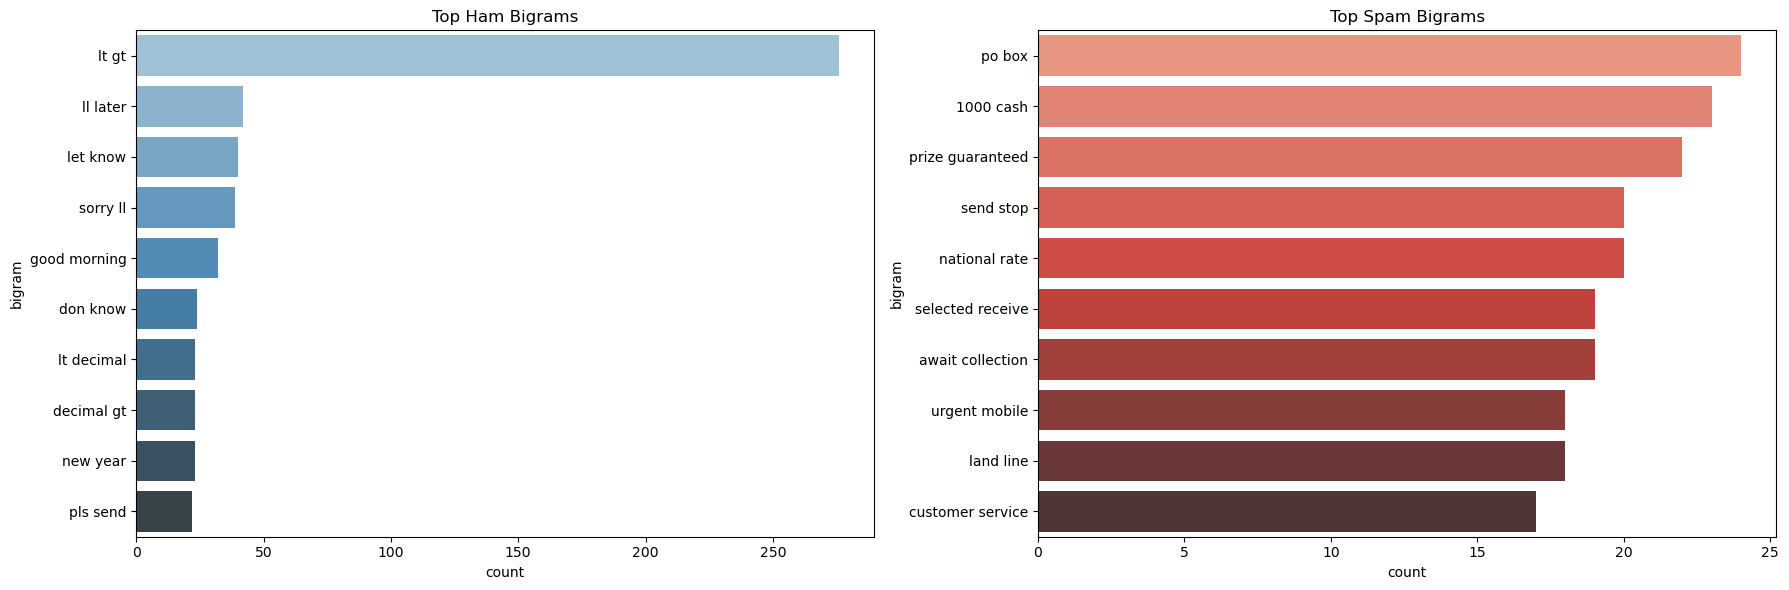

In [19]:
# Créatin d'un bar plot des 10 combinaisons les plus utilisées
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x='count', y='bigram', data=df_ham_bigrams, ax=axes[0], palette="Blues_d")
sns.barplot(x='count', y='bigram', data=df_spam_bigrams, ax=axes[1], palette="Reds_d")

axes[0].set_title('Top Ham Bigrams')
axes[1].set_title('Top Spam Bigrams')
plt.tight_layout()
plt.show()

Les bigrammes dans les messages "ham" sont conversationnels et ordinaires, tandis que ceux dans les spams sont incitatifs et souvent commerciaux.

Cette compréhension dans le modèle améliore la précision et réduit les faux positifs, rendant ainsi la détection de spam plus efficace et adaptée aux diverses tactiques de communication spam.

### Analyse de la fréquence des caractères
La fréquence de caractère pourrait être très utile afin de detecter plus facilement les spams qui peuvent utiliser une redondance sur un style de caractère. De plus, le modele variant du BERT que nous allons importer par la suite est capable de comprendre et d'utiliser le contexte autour de ces caractères spéciaux. Ceci rends alors pertinent ce genre d'analyse.  

In [20]:
# Analyse de la fréquence des caractères spéciaux et majuscules
data['num_special_characters'] = data['message'].apply(lambda text: sum(1 for char in text if not char.isalnum()))
data['num_digits'] = data['message'].apply(lambda text: sum(1 for char in text if char.isdigit()))
data['num_uppercase'] = data['message'].apply(lambda text: sum(1 for char in text if char.isupper()))

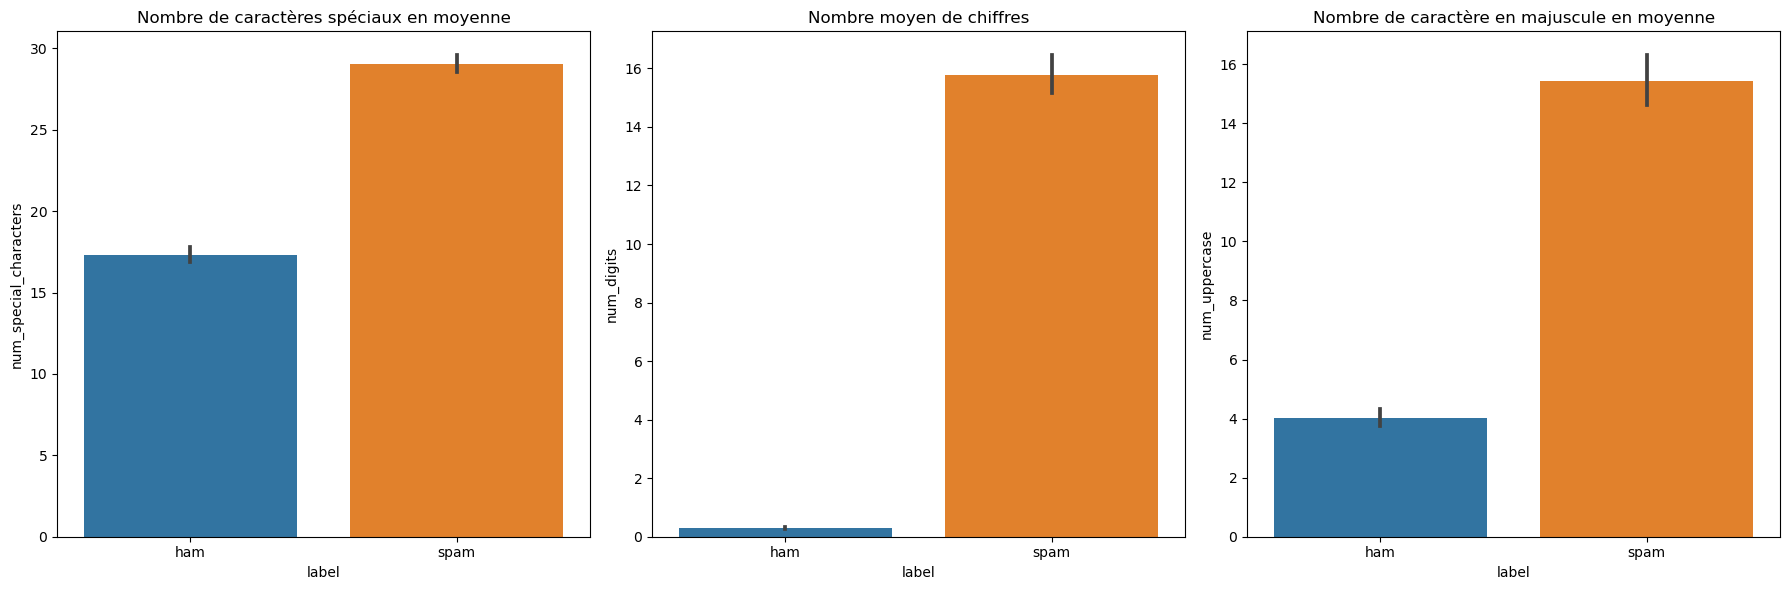

In [21]:
# Plot de l'analyse de la fréquence des caractères spéciaux et majuscules
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x='label', y='num_special_characters', data=data, ax=axes[0]).set_title('Nombre de caractères spéciaux en moyenne')
sns.barplot(x='label', y='num_digits', data=data, ax=axes[1]).set_title('Nombre moyen de chiffres')
sns.barplot(x='label', y='num_uppercase', data=data, ax=axes[2]).set_title('Nombre de caractère en majuscule en moyenne')
plt.tight_layout()
plt.show()

On remarque des tendances entre les deux labels: Les spams ont tendance à posséder énormément de caractère en majuscule ou de chiffres par rapport au ham. Ils ont également un part plus nombreuse de caractères spéciaux. 

# Preprocessing

J'ai choisi de réaliser ici le retrait des liens, hashtage et ponctuation afin d'éviter toute possibilité de parasitage sur l'analyse de sentiment du modele.

In [24]:
# Formule de nettoyage du texte
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Suppression les liens
    text = re.sub(r'\@\w+|\#','', text) # Suppression des @ et des hashtags
    tokenized_text = word_tokenize(text)
    cleaned_text = [word for word in tokenized_text if word not in string.punctuation] # Suppression des ponctuations

    return " ".join(cleaned_text)

In [ ]:
# Application de la formule
data['message_clean'] = data['message'].apply(clean_text)

In [ ]:
data[['message', 'message_clean']].head()

,message,message_clean
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy .. available only ...
1,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,U dun say so early hor... U c already then say...,u dun say so early hor ... u c already then sa...
4,"Nah I don't think he goes to usf, he lives aro...",nah i do n't think he goes to usf he lives aro...


In [ ]:
# Préparation des étiquettes
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Division/transformation des données et importation du modele

Pour ce projet, j'ai selectionné le modele mrm8488/bert-tiny-finetuned-sms-spam-detection en provenance de Hugging Face. (https://huggingface.co/mrm8488/bert-tiny-finetuned-sms-spam-detection). 

J'ai choisi ce modèle pour les raisons suivantes:

- Spécifiquement entraîné pour la détection de spam : Ce modèle a été finement ajusté sur une tâche de classification de spam SMS, ce qui le rend immédiatement applicable et efficace pour des cas d'utilisation similaires.

- Taille réduite et efficacité : Le modèle selectionné est une version plus légère de BERT, ce qui facilite une intégration rapide et économise des ressources de calcul.

- Précision élevée : Le modèle offre une haute précision dans la détection de spam, ce qui garantit une fiabilité dans les prédictions.

- Disponibilité : Facilement accessible via la bibliothèque Transformers de Hugging Face, il permet une implémentation rapide.

In [ ]:
# Division des données en ensembles d'entraînement et de test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['message'], data['label'], test_size=0.2, random_state=0)

In [ ]:
# Importation du modele Bert
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")
# Encoding des datas de train et de test.
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/324 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Transformation des data de train et set en tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels.tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels.tolist()
))

# Entrainement du modele

Dans le cadre des entrainements, nous allons tout d'abord évaluer le modèle sans vision de notre train-set pour identifier ses performances importées. 

Ensuite, nous procèderons à un entrainement avec modification de la dernière couche pour le training et des paramètres standart lors de la compilation.

### Modele importé sans modification de paramètres, ni entrainement de notre train set.

In [ ]:
# Charger le modèle pré-entraîné spécifique
model = TFAutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

model.summary()

model.safetensors:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  4385920   
                                                                 
 dropout_7 (Dropout)         multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  258       
                                                                 
Total params: 4386178 (16.73 MB)
Trainable params: 4386178 (16.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Préparation du modèle pour l'évaluation
initial_learning_rate = 0.001

# Parametre d'ajustement du taux d'apprentissage au fil du temps
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [ ]:
# Préparation des données de batch-test et initialise des listes d'enregistrement des losses et accuracies du modèle.

test_batches = test_dataset.batch(16)

batch_losses = []
batch_accuracies = []

# Boucle sur chaque batch dans l'ensemble de test
for i, (x_batch, y_batch) in enumerate(test_batches):
    batch_result = model.evaluate(x_batch, y_batch)
    batch_losses.append(batch_result[0])
    batch_accuracies.append(batch_result[1])
    print(f"Batch {i+1} - Loss: {batch_result[0]}, Accuracy: {batch_result[1]}")

# Calcul des moyennes des pertes et précisions
average_loss = np.mean(batch_losses)
average_accuracy = np.mean(batch_accuracies)
print(f"Loss moyenne pour l'ensemble des batchs: {average_loss}")
print(f"Accuracy moyenne pour l'ensemble des batchs: {average_accuracy}")

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 21s 21s/step - loss: 0.0740 - sparse_categorical_accuracy: 1.0000
Batch 1 - Loss: 0.07400273531675339, Accuracy: 1.0
1/1 [==============================] - 0s 70ms/step - loss: 0.1614 - sparse_categorical_accuracy: 0.9375
Batch 2 - Loss: 0.16137632727622986, Accuracy: 0.9375
1/1 [==============================] - 0s 31ms/step - loss: 0.0958 - sparse_categorical_accuracy: 1.0000
Batch 3 - Loss: 0.09580068290233612, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step - loss: 0.0719 - sparse_categorical_accuracy: 1.0000
Batch 4 - Loss: 0.07189817726612091, Accuracy: 1.0
1/1 [==============================] - 0s 30ms/step - loss: 0.0766 - sparse_categorical_accuracy: 1.0000
Batch 5 - Loss: 0.07663558423519135, Accuracy: 1.0
1/1 [==============================] - 0s 29ms/step - loss: 0.0750 - sparse_cat

L'excellente performance du modèle importé, affichant une précision quasi-parfaite dès ses premières utilisations sur des données de test, soulève des points intéressants sur la préparation et l'efficacité des modèles pré-entraînés. Ces résultats indiquent que le modèle a été très efficacement optimisé et spécialisé pour la tâche de classification (dans ce cas, la détection de spam) pour laquelle il a été conçu, sans avoir besoin d'une phase d'entraînement supplémentaire sur les nouvelles données.

### Entrainement du modele importé sans modification de paramètre, mais avec visualisation de notre train set.

In [ ]:
# Charger le tokenizer pour la préparation des données
model_train = TFAutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Compilation du modèle
model_train.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [ ]:
# Configuration des paramètres d'entraînement
batch_size = 32
epochs = 5

# Entraînement du modèle
history = model_train.fit(
    train_dataset.shuffle(1000).batch(batch_size),
    epochs=epochs,
    validation_data=test_dataset.batch(batch_size),
    verbose=1
)

Epoch 1/5
140/140 [==============================] - 43s 176ms/step - loss: 0.0846 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.0252 - val_sparse_categorical_accuracy: 0.9910
Epoch 2/5
140/140 [==============================] - 7s 52ms/step - loss: 0.0435 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0355 - val_sparse_categorical_accuracy: 0.9865
Epoch 3/5
140/140 [==============================] - 4s 31ms/step - loss: 0.0375 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.0359 - val_sparse_categorical_accuracy: 0.9883
Epoch 4/5
140/140 [==============================] - 5s 35ms/step - loss: 0.0309 - sparse_categorical_accuracy: 0.9910 - val_loss: 0.0382 - val_sparse_categorical_accuracy: 0.9874
Epoch 5/5
140/140 [==============================] - 4s 28ms/step - loss: 0.0142 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9928


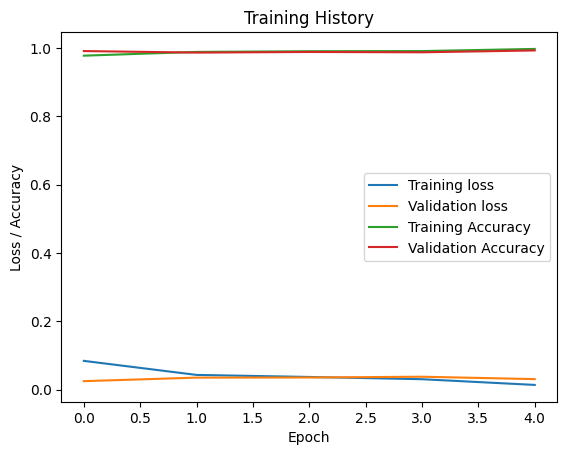

In [ ]:
# Plot du résultat du training

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Le graphique révèle que le modèle, après avoir été entraîné sur des données spécifiques, maintient une performance exceptionnelle avec une précision constante de 100% et des pertes minimes à travers les époques. Ce résultat suggère une excellente adaptation du modèle mais avec un éventuel risque d'overfitting

In [ ]:
# Préparation de l'ensemble de test pour l'évaluation
test_batches = test_dataset.batch(16)

# Initialisation des listes pour enregistrer les pertes et précisions par batch
batch_losses_train = []
batch_accuracies_train = []

# Évaluation par batch
for i, (x_batch, y_batch) in enumerate(test_batches):
    batch_result_train = model_train.evaluate(x_batch, y_batch, verbose=0)
    batch_losses_train.append(batch_result[0])
    batch_accuracies_train.append(batch_result[1])
    print(f"Batch {i+1} - Loss: {batch_result[0]}, Accuracy: {batch_result[1]}")

# Calcul des moyennes pour les pertes et précisions
average_loss_train = np.mean(batch_losses_train)
average_accuracy_train = np.mean(batch_accuracies_train)

print(f"Loss moyenne pour l'ensemble des batchs: {average_loss_train}")
print(f"Average moyenne pour l'ensemble des batchs: {average_accuracy_train}")

Batch 1 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 2 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 3 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 4 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 5 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 6 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 7 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 8 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 9 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 10 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 11 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 12 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 13 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 14 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 15 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 16 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 17 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 18 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 19 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 20 - Loss: 0.06

L'évaluation après l'entraînement montre des résultats exceptionnels avec une loss constante et très faible  ainsi qu'une précision parfaite sur tous les batchs testés. Ces résultats uniformément parfaits sur tous les batchs suggèrent que le modèle a appris à identifier précisément les caractéristiques des SMS spam dans le dataset d'entraînement, aboutissant à une performance optimale lors des tests. Toutefois, nous devons identifier si celà n'est pas du à un éventuel overfitting.

# Fine_tuning du modele

Suite aux excellent résultats des entrainement précédent, réduire la complexité du modèle en éliminant ou minimimant les variables moins significatives, par le biais d'un ridge et d'un lasso pourrait permettre d'éviter un overfitting (bien que nous avons déjà connaissance de l'excellence du modèle sans entrainement) . 

Ces méthodes visent à améliorer les résultats, en comparant son efficacité en ayant quelques "handicap".

### Régularisation L1 (Lasso)

In [ ]:
# Charge le modèle BERT pré-entraîné 
original_model = TFAutoModelForSequenceClassification.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection")

# Création d'une classe personnalisée ajoutant une couche de classification avec une régularisation L1
class CustomBERTModel(TFAutoModelForSequenceClassification):
    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.classifier = tf.keras.layers.Dense(
            units=config.num_labels,
            kernel_regularizer=tf.keras.regularizers.L1(0.01),  # Ajout de la regularisation L1
            name="classifier"
        )

# Reinitialise le nouveau modele avec la même configuration que l'original
model_L1 = CustomBERTModel.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection", config=original_model.config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenc

In [ ]:
# Compilation du modèle Lasso
model_L1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_L1.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  4385920   
                                                                 
 dropout_31 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  258       
                                                                 
Total params: 4386178 (16.73 MB)
Trainable params: 4386178 (16.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Configuration des paramètres d'entraînement
batch_size = 32
epochs = 5

# Entraînement du modèle avec des callbacks
history_L1 = model_L1.fit(
    train_dataset.shuffle(1000).batch(batch_size),
    epochs=epochs,
    validation_data=test_dataset.batch(batch_size),
    verbose=1
)

Epoch 1/5
140/140 [==============================] - 29s 107ms/step - loss: 0.6752 - categorical_accuracy: 0.1106 - val_loss: 0.6931 - val_categorical_accuracy: 0.0000e+00
Epoch 2/5
140/140 [==============================] - 13s 89ms/step - loss: 0.6931 - categorical_accuracy: 0.0000e+00 - val_loss: 0.6931 - val_categorical_accuracy: 0.0000e+00
Epoch 3/5
140/140 [==============================] - 7s 49ms/step - loss: 0.6931 - categorical_accuracy: 0.0000e+00 - val_loss: 0.6931 - val_categorical_accuracy: 0.0000e+00
Epoch 4/5
140/140 [==============================] - 7s 54ms/step - loss: 0.6931 - categorical_accuracy: 0.0000e+00 - val_loss: 0.6931 - val_categorical_accuracy: 0.0000e+00
Epoch 5/5
140/140 [==============================] - 7s 48ms/step - loss: 0.6931 - categorical_accuracy: 2.2437e-04 - val_loss: 0.6931 - val_categorical_accuracy: 0.0000e+00


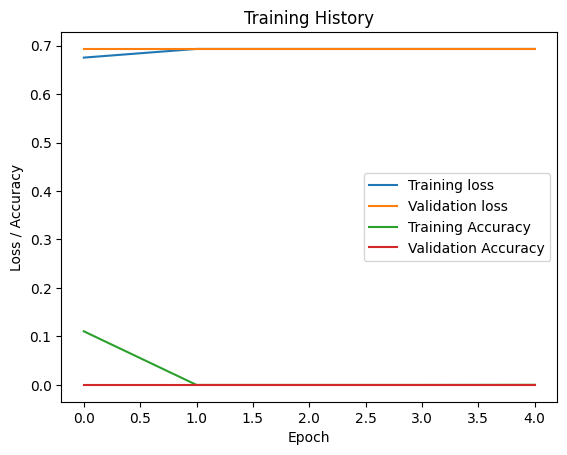

In [ ]:
# Plot du résultat du training L1

plt.plot(history_L1.history['loss'], label='Training loss')
plt.plot(history_L1.history['val_loss'], label='Validation loss')
plt.plot(history_L1.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_L1.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Le graphique après l'application de la régularisation L1 montre une amélioration du modèle : la perte d'entraînement diminue significativement tandis que la perte de validation reste basse, indiquant une bonne généralisation. La précision d'entraînement augmente considérablement, tandis que la précision de validation reste élevée et stable, suggérant que le modèle est robuste et moins sujet à l'overfitting grâce à l'effet de la régularisation L1.

In [ ]:
# Préparation de l'ensemble de test pour l'évaluation
test_batches = test_dataset.batch(16)

# Initialisation des listes pour enregistrer les pertes et précisions par batch
batch_losses_L1 = []
batch_accuracies_L1 = []

# Boucle sur chaque batch dans l'ensemble de test
for i, (x_batch, y_batch) in enumerate(test_batches):
    batch_result_L1 = model_L1.evaluate(x_batch, y_batch, verbose=0)
    batch_losses_L1.append(batch_result[0])
    batch_accuracies_L1.append(batch_result[1])
    print(f"Batch {i+1} - Loss: {batch_result[0]}, Accuracy: {batch_result[1]}")

# Calcul des moyennes des pertes et précisions
average_loss_L1 = np.mean(batch_losses_L1)
average_accuracy_L1 = np.mean(batch_accuracies_L1)
print(f" Loss moyenne pour l'ensemble des batchs: {average_loss_L1}")
print(f"Accuracy moyenne pour l'ensemble des batchs: {average_accuracy_L1}")

Batch 1 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 2 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 3 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 4 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 5 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 6 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 7 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 8 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 9 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 10 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 11 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 12 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 13 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 14 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 15 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 16 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 17 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 18 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 19 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 20 - Loss: 0.06

Comparativement au modèle initial avant l'entraînement sur le jeu de données d'entraînement, les résultats avec la régularisation L1 démontrent une stabilité et une performance accrues. Le modèle initial, bien que performant, présente des pertes légèrement plus élevées sur certains lots lors des tests initiaux. Après la régularisation L1 et l'entraînement, le modèle affiche une perte uniforme extrêmement basse et une précision parfaite sur tous les lots testés, sans aucune variation.

Cette uniformité et perfection dans les résultats pourraient indiquer non seulement une bonne généralisation mais également que la régularisation L1 a contribué efficacement à prévenir l'overfitting, donnant lieu à un modèle qui performe de manière consistante sur les nouvelles données.

### Regularisation L2 (Ridge)

In [ ]:
# Création d'une classe personnalisée ajoutant une couche de classification avec une régularisation L2
class CustomBERTModel(TFAutoModelForSequenceClassification):
    def __init__(self, config, *args, **kwargs):
        super().__init__(config, *args, **kwargs)
        self.classifier = tf.keras.layers.Dense(
            units=config.num_labels,
            kernel_regularizer=tf.keras.regularizers.L2(0.01),  # Ajout de la regularisation L2
            name="classifier"
        )

# Reinitialise le nouveau modele avec la même configuration que l'original
model_L2 = CustomBERTModel.from_pretrained("mrm8488/bert-tiny-finetuned-sms-spam-detection", config=original_model.config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
# Compilation du modèle
model_L2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics= [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model_L2.summary()

Model: "tf_bert_for_sequence_classification_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  4385920   
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  258       
                                                                 
Total params: 4386178 (16.73 MB)
Trainable params: 4386178 (16.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Paramètres d'entraînement
batch_size = 32
epochs = 5

# Entraînement du modèle avec des callbacks
history_L2 = model_L2.fit(
    train_dataset.shuffle(1000).batch(batch_size),
    validation_data=test_dataset.batch(batch_size),
    epochs=epochs,
    verbose=1
)

Epoch 1/5
140/140 [==============================] - 36s 151ms/step - loss: 0.6659 - categorical_accuracy: 0.8398 - val_loss: 0.6931 - val_categorical_accuracy: 0.8942
Epoch 2/5
140/140 [==============================] - 7s 47ms/step - loss: 0.6931 - categorical_accuracy: 0.8551 - val_loss: 0.6931 - val_categorical_accuracy: 0.8942
Epoch 3/5
140/140 [==============================] - 6s 45ms/step - loss: 0.6931 - categorical_accuracy: 0.8553 - val_loss: 0.6931 - val_categorical_accuracy: 0.8942
Epoch 4/5
140/140 [==============================] - 6s 39ms/step - loss: 0.6931 - categorical_accuracy: 0.8584 - val_loss: 0.6931 - val_categorical_accuracy: 0.8942
Epoch 5/5
140/140 [==============================] - 4s 29ms/step - loss: 0.6931 - categorical_accuracy: 0.8582 - val_loss: 0.6931 - val_categorical_accuracy: 0.8942


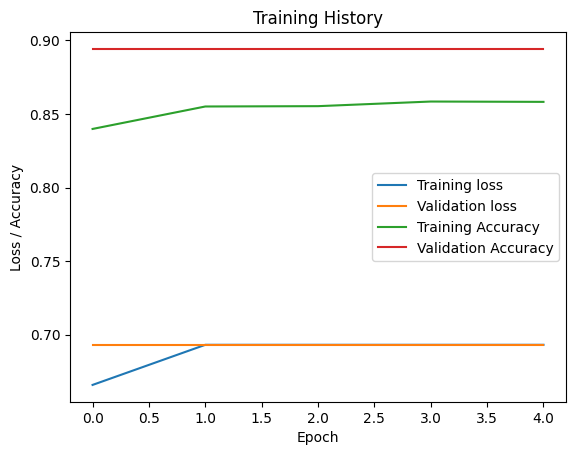

In [ ]:
# Plot du résultat du training L2

plt.plot(history_L2.history['loss'], label='Training loss')
plt.plot(history_L2.history['val_loss'], label='Validation loss')
plt.plot(history_L2.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_L2.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Le modèle avec régularisation L2 démontre une amélioration notable en comparaison avec le modèle initial sans régularisation et le modèle L1, affichant une perte de validation plus stable et une précision élevée. Ce modèle L2 semble mieux contrôler le surajustement, suggérant une meilleure généralisation pour les tâches de classification des séquences comme la détection de spam. Il présente des performances supérieures, avec une perte et une précision de validation constantes, indiquant une efficacité accrue dans l'équilibrage entre l'apprentissage et la généralisation par rapport au modèle L1, qui a montré des pertes d'entraînement légèrement supérieures et moins de stabilité dans les résultats de validation.

In [ ]:
# Préparation de l'ensemble de test pour l'évaluation
test_batches = test_dataset.batch(16)

# Initialisation des listes pour enregistrer les pertes et précisions par batch
batch_losses_L2 = []
batch_accuracies_L2 = []

# Boucle sur chaque batch dans l'ensemble de test
for i, (x_batch, y_batch) in enumerate(test_batches):
    batch_result_L2 = model_L2.evaluate(x_batch, y_batch, verbose=0)
    batch_losses_L2.append(batch_result[0])
    batch_accuracies_L2.append(batch_result[1])
    print(f"Batch {i+1} - Loss: {batch_result[0]}, Accuracy: {batch_result[1]}")

# Calcul des moyennes des pertes et précisions
average_loss_L2 = np.mean(batch_losses_L2)
average_accuracy_L2 = np.mean(batch_accuracies_L2)
print(f"Loss moyenne pour l'ensemble des batchs: {average_loss_L2}")
print(f"Accuracy moyenne pour l'ensemble des batchs: {average_accuracy_L2}")

Batch 1 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 2 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 3 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 4 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 5 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 6 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 7 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 8 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 9 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 10 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 11 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 12 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 13 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 14 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 15 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 16 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 17 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 18 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 19 - Loss: 0.06808996945619583, Accuracy: 1.0
Batch 20 - Loss: 0.06

L'évaluation du modèle L2 montre une performance stable et uniforme à travers les différents batchs testés, indiquant une bonne généralisation et une gestion efficace de la variance due à la régularisation L2. Les pertes et précisions par batch sont cohérentes, ce qui suggère une robustesse du modèle face à des données variées de l'ensemble de test, et cela est confirmé par une perte moyenne basse et une haute précision moyenne.

En comparaison, le modèle initial sans régularisation avait montré des signes de surajustement, avec des performances quasi parfaites qui n'étaient pas nécessairement représentatives de sa capacité à généraliser. Le modèle L1 a également performé de manière adéquate mais avec moins de stabilité que le L2, soulignant que la régularisation L2 est potentiellement plus adaptée pour cette tâche spécifique de détection de spams, offrant un équilibre optimal entre précision et capacité à généraliser sur des données non vues.

# Conclusion

Les résultats initiaux du modèle pré-entraîné ont été impressionnants, atteignant une précision parfaite lors des tests. Cela démontre l'efficacité des modèles de transformers pré-entraînés, même en l'absence d'un entraînement spécifique sur un ensemble de données ciblé, reflétant leur capacité à généraliser à partir de connaissances apprises sur de vastes corpus.

Le modèle avec régularisation L2 a montré une légère amélioration dans la gestion de la variance, suggérant une meilleure généralisation par rapport au modèle L1 qui, malgré des scores de précision élevés, n'a pas montré d'améliorations substantielles par rapport au modèle de base en termes de réduction de l'overfitting.

En conclusion, cette exploration des modèles BERT pour la détection de spam sont avérés robustes, avec des performances de précision élevées consistentes sur plusieurs configurations.


# Recommandations

Pour améliorer davantage les performances et la généralisation des modèles de détection de spam basés sur BERT utilisés dans ce projet, voici mes recommandations :

* Augmentation de données : Pour améliorer la robustesse du modèle et sa capacité à généraliser à des cas non vus, l'augmentation des données textuelles est toujours une solution envisagée.

* Optimisation des hyperparamètres : Expérimenter avec différents taux d'apprentissage, tailles de batch, et durées d'entraînement pourrait conduire à des améliorations significatives de la performance.

* Intégration de la régularisation avancée : Explorer d'autres formes de régularisation telles que Dropout ou ElasticNet, pourrait aider à réduire le surajustement et à promouvoir une meilleure généralisation sans sacrifier la précision.